<a href="https://colab.research.google.com/github/Nicolepcx/Human-Pose-Estimation/blob/master/Human_Pose_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook uses the API rather than firstly download the required images for this task. It would be to tedious to first download the datasets and then upload them to Google Drive connect the storage via verification in order to be to be able to use them for the training...

In [0]:
# usual imports

import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import os, sys, zipfile
import urllib.request
import shutil
import numpy as np
import skimage.io as io
import pylab


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [3]:
##########################
### SVHN-Dataset
##########################



train_dataset = datasets.SVHN(root='./data', #data root directory
                                          split='train', #The training set
                                          download=True, #checks if data has downloaded else does so  
                                        transform = transforms.ToTensor())  #transforms to tensor)

test_dataset = datasets.SVHN(root='./data', #data root directory
                                          split='test', #The testing set
                                          download=True, #checks if data has downloaded else does so  
                                        transform = transforms.ToTensor())  #transforms to tensor) 




Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [4]:
train_dataset

Dataset SVHN
    Number of datapoints: 73257
    Root location: ./data
    Split: train
    StandardTransform
Transform: ToTensor()

In [5]:
test_dataset

Dataset SVHN
    Number of datapoints: 26032
    Root location: ./data
    Split: test
    StandardTransform
Transform: ToTensor()

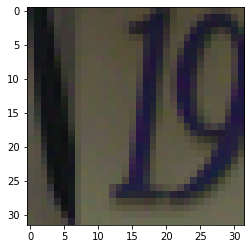

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

torchimage=train_dataset[0][0]    #Indexes the first element of the first tuple ie the 1st image
npimage=torchimage.permute(1, 2, 0) #changes the axis C H W to H W C
plt.imshow(npimage)

### preparation for traing

In [0]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 256
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = "cuda:1"
GRAYSCALE = False

In [10]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=8,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=8,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([256, 3, 32, 32])
Image label dimensions: torch.Size([256])
Image batch dimensions: torch.Size([256, 3, 32, 32])
Image label dimensions: torch.Size([256])


In [1]:
# install alternative COCO API - the original only supports python 2.7
!pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI

  Cloning https://github.com/philferriere/cocoapi.git to /tmp/pip-req-build-hiy14qgr
  Running command git clone -q https://github.com/philferriere/cocoapi.git /tmp/pip-req-build-hiy14qgr
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=275416 sha256=01d4b894e0d917359bca61c0de0abc657a5cba451b1e70bf1ec3c793d900b43a
  Stored in directory: /tmp/pip-ephem-wheel-cache-qecajii0/wheels/69/2b/12/2fa959e49f73d26cff202c2f4e5079096c9c57c8a8509fd75c
Successfully built pycocotools


In [0]:
##########################
### COCO-Dataset
##########################

from pycocotools.coco import COCO

# Setup data paths
dataDir = '../..'
dataType = 'val2017'
annDir = '{}/annotations'.format(dataDir)
annZipFile = '{}/annotations_train{}.zip'.format(dataDir, dataType)
annFile = '{}/instances_{}.json'.format(annDir, dataType)
annURL = 'http://images.cocodataset.org/annotations/annotations_train{}.zip'.format(dataType)



In [9]:
# Download data if not available locally
if not os.path.exists(annDir):
    os.makedirs(annDir)
if not os.path.exists(annFile):
    if not os.path.exists(annZipFile):
        print ("Downloading zipped annotations to " + annZipFile + " ...")
        with urllib.request.urlopen(annURL) as resp, open(annZipFile, 'wb') as out:
            shutil.copyfileobj(resp, out)
        print ("... done downloading.")
    print ("Unzipping " + annZipFile)
    with zipfile.ZipFile(annZipFile,"r") as zip_ref:
        zip_ref.extractall(dataDir)
    print ("... done unzipping")
print ("Will use annotations in " + annFile)

... done downloading.
Unzipping ../../annotations_trainval2017.zip
... done unzipping
Will use annotations in ../../annotations/instances_val2017.json


In [10]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


In [11]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
furniture kitchen outdoor indoor appliance person vehicle electronic animal sports accessory food


In [0]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog','skateboard']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

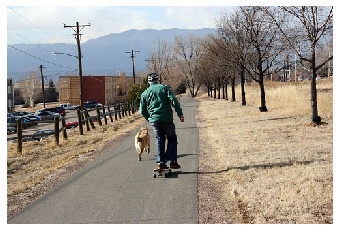

In [13]:
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

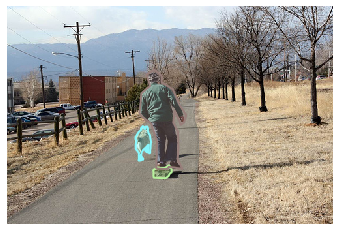

In [15]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [16]:
# initialize COCO api for person keypoints annotations
annFile = '{}/annotations/person_keypoints_{}.json'.format(dataDir,dataType)
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


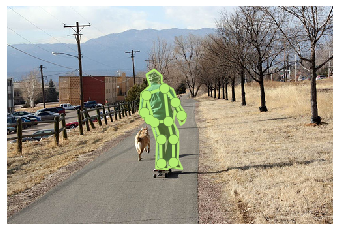

In [17]:
# load and display keypoints annotations
plt.imshow(I); plt.axis('off')
ax = plt.gca()
annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_kps.loadAnns(annIds)
coco_kps.showAnns(anns)

In [18]:
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


A man is skate boarding down a path and a dog is running by his side.
A man on a skateboard with a dog outside. 
A person riding a skate board with a dog following beside.
This man is riding a skateboard behind a dog.
A man walking his dog on a quiet country road.


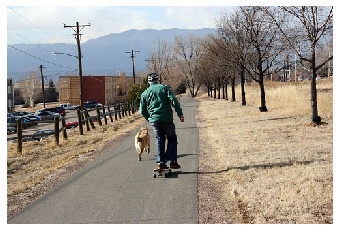

In [19]:
# load and display caption annotations
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.imshow(I); plt.axis('off'); plt.show()